# Make Figure 3A: EGFR mutation status

This notebooks makes Figure 3A. It shows the mutation type abundance for EGFR across the different cancers. It uses the harmonzied mutation data from the cptac pancan package. 

In [1]:
import cptac
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plot_utils as p
import cptac.pancan as pc

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import warnings
warnings.filterwarnings('ignore')
#cptac version
cptac.version()   

'0.9.1'

In [ ]:
#pc.download("pancancoad", redownload = True)

# Step 1 Create data frames with Mutation Types 

For each cancer type we need to create a df that has the mutation type for each sample. 


First, load in cptac pancan datasets

In [3]:
g = pc.PancanGbm()
hn = pc.PancanHnscc()
l = pc.PancanLuad()
o = pc.PancanOv()
c = pc.PancanCcrcc()
col = pc.PancanCoad()
b = pc.PancanBrca()
ls = pc.PancanLscc()
en = pc.PancanUcec()

In [4]:
colon = col.get_genotype_all_vars("EGFR", omics_source = "washu")


Second, call get_geneotype_all_vars for EGFR for each cancer type. This returns a df with mutation, location, and mutation_status. For individuals with multiple mutations, we report a single mutation type based on the following priority: deletion, truncation, missense, amplification, inframe, silent, and wildtype.

In [5]:
endo = en.get_genotype_all_vars("EGFR", omics_source = "washu")
gbm = g.get_genotype_all_vars("EGFR", omics_source = "washu")
hnscc = hn.get_genotype_all_vars("EGFR", omics_source = "washu")
ovar = o.get_genotype_all_vars("EGFR", omics_source = "washu")
cc = c.get_genotype_all_vars("EGFR", omics_source = "washu")
colon = col.get_genotype_all_vars("EGFR", omics_source = "washu")
ld = l.get_genotype_all_vars("EGFR", omics_source = "washu")
brca = b.get_genotype_all_vars("EGFR", omics_source = "washu")
lscc = ls.get_genotype_all_vars("EGFR", omics_source = "washu")

In [7]:
#example 
colon

Name,Mutation,Location,Mutation_Status
Patient_ID,,,
01CO001,Wildtype_Tumor,No_mutation,Wildtype_Tumor
01CO005,Amplification,Amplification,Single_mutation
01CO006,Wildtype_Tumor,No_mutation,Wildtype_Tumor
01CO008,Wildtype_Tumor,No_mutation,Wildtype_Tumor
01CO013,Wildtype_Tumor,No_mutation,Wildtype_Tumor
...,...,...,...
21CO007,Amplification,Amplification,Single_mutation
22CO004,Amplification,Amplification,Single_mutation
22CO006,Wildtype_Tumor,No_mutation,Wildtype_Tumor


# Step 2: Match Mutation Labels

Change labels to to match desired final figure. 

In [9]:
# Simplify mutation names
dfs = [endo, gbm, hnscc, cc, ld, brca, lscc, colon,ovar]
for df in dfs:
    df['Mutation'].where(df['Mutation'] != 'Missense_Mutation', 'Missense', inplace = True) # replaces when false
    df['Mutation'].where(df['Mutation'] != 'Wildtype_Tumor', 'Wildtype', inplace = True)
    df['Mutation'].where(df['Mutation'] != 'In_Frame_Del', 'Indel', inplace = True)
    df['Mutation'].where(df['Mutation'] != 'Nonsense_Mutation', 'Truncation', inplace = True)
    


In [10]:

#Drop Silent mutation type
indexNames = hnscc[ hnscc['Mutation'] == "Silent" ].index
hnscc.drop(indexNames , inplace=True)
indexNames = ld[ ld['Mutation'] == "Silent" ].index
ld.drop(indexNames , inplace=True)
indexNames = brca[ brca['Mutation'] == "Silent" ].index
brca.drop(indexNames , inplace=True)

#Drop Intron
indexNames = hnscc[ hnscc['Mutation'] == "Intron" ].index
hnscc.drop(indexNames , inplace=True)                  

# Step 3: Create figure 

Put dfs into a list. Create list of names for figure legend. 
Call plot_mutations function.

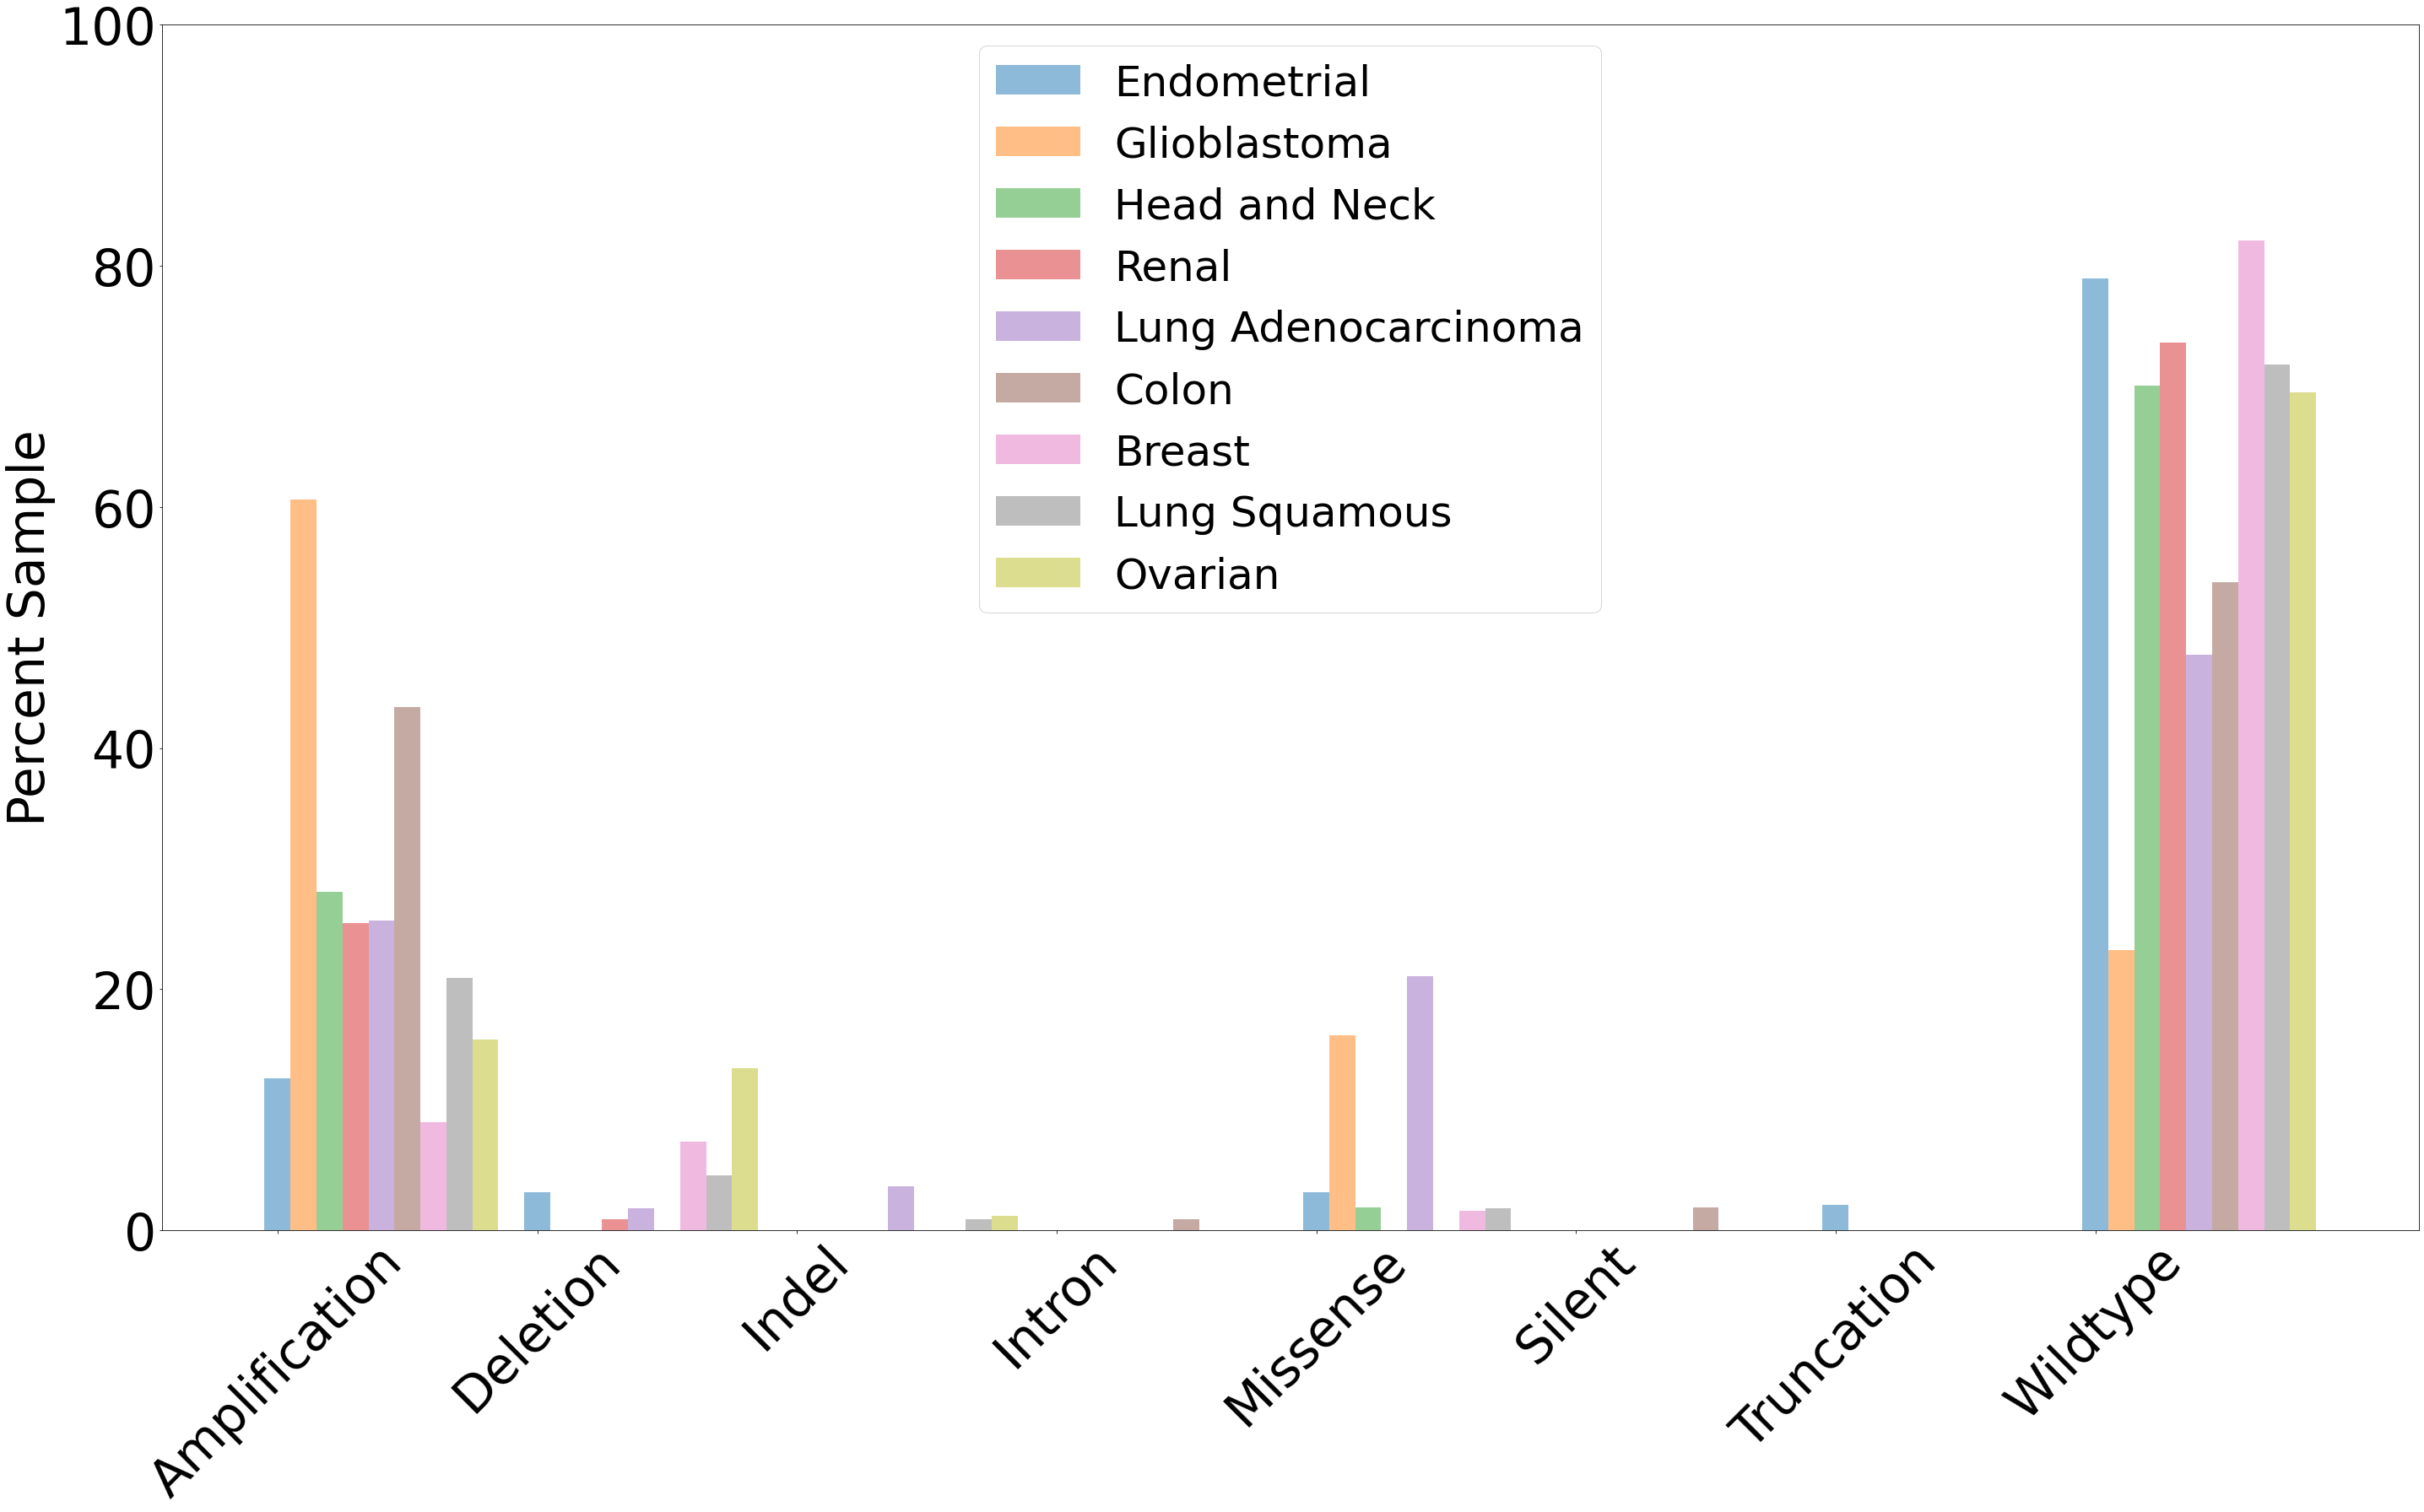

In [13]:
dfs = [endo, gbm, hnscc, cc, ld,colon, brca, lscc,ovar]
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Renal', 'Lung Adenocarcinoma', "Colon", 'Breast',"Lung Squamous","Ovarian"]
p.figure1_plot_mutations(dfs, names, save_to_path = "png_files/Figure3A.png")

# Calculate Percent of samples with Amplification mutations

The manuscript mentions the exact percentage of EGFR amplification mutations. Here is where we derive those percentages. 

In [14]:
#Calculate exact percent
i = 0
for cancer in dfs:

    vc = cancer.Mutation.value_counts()
    total = len(cancer)
    cnv_amp = vc.Amplification
    print(names[i])
    print('total_samples:',total,'\n')
    print(cnv_amp,'/',total,'=', cnv_amp/total,'\n')
    i += 1
   

Endometrial
total_samples: 95 

12 / 95 = 0.12631578947368421 

Glioblastoma
total_samples: 99 

60 / 99 = 0.6060606060606061 

Head and Neck
total_samples: 107 

30 / 107 = 0.2803738317757009 

Renal
total_samples: 110 

28 / 110 = 0.2545454545454545 

Lung Adenocarcinoma
total_samples: 109 

28 / 109 = 0.25688073394495414 

Colon
total_samples: 106 

46 / 106 = 0.4339622641509434 

Breast
total_samples: 123 

11 / 123 = 0.08943089430894309 

Lung Squamous
total_samples: 110 

23 / 110 = 0.20909090909090908 

Ovarian
total_samples: 82 

13 / 82 = 0.15853658536585366 



In [16]:
brca_CNV = b.get_CNV()
combined = brca_CNV[["EGFR"]]
combined

Name,EGFR
Database_ID,ENSG00000146648.14
Patient_ID,
01BR001,0.69484
01BR008,-0.00576
01BR009,0.16028
01BR010,0.13308
01BR015,0.04930
...,...
21BR010,0.08065
22BR005,-0.14489


In [17]:
mutations_genes = "EGFR"
def add_del_and_amp(row):
            if row[mutations_genes] <= -.2:
                mutations = row[mutations_genes+"_Mutation"] + ['Deletion']
                locations = row[mutations_genes+'_Location']+['Deletion']

            elif row[mutations_genes] >= .2:
                mutations = row[mutations_genes+"_Mutation"] + ['Amplification']
                locations = row[mutations_genes+'_Location']+['Amplification']
            else:
                mutations = row[mutations_genes+"_Mutation"]
                locations = row[mutations_genes+"_Location"]

            return mutations, locations


#combined['mutations'], combined['locations'] = zip(*combined.apply(add_del_and_amp, axis=1))
       

# Check CNV numbers vs Flagship papers 

In [20]:
og_b = cptac.Brca()

In [21]:
brca_cnv = b.get_CNV(source = "washu")
brca_cnv = brca_cnv[["EGFR"]]
brca_cnv = brca_cnv.rename(columns = {"EGFR":"EGFR_Pancan"})
brca_cnv

Name,EGFR_Pancan
Database_ID,ENSG00000146648.14
Patient_ID,
01BR001,0.69484
01BR008,-0.00576
01BR009,0.16028
01BR010,0.13308
01BR015,0.04930
...,...
21BR010,0.08065
22BR005,-0.14489


In [22]:
og_b_CNV = og_b.get_CNV()
og_b_CNV = og_b_CNV[["EGFR"]]
og_b_CNV = og_b_CNV.rename(columns = {"EGFR":"EGFR_Flagship"})
og_b_CNV

Name,EGFR_Flagship
Database_ID,ENSG00000146648.11
Patient_ID,
CPT000814,-0.471
CPT001846,1.288
X01BR001,2.199
X01BR008,0.114
X01BR009,0.582
...,...
X21BR001,-0.099
X21BR002,0.016


In [23]:
og_b_CNV.index = og_b_CNV.index.str.replace(r'X', '')
og_b_CNV

Name,EGFR_Flagship
Database_ID,ENSG00000146648.11
Patient_ID,
CPT000814,-0.471
CPT001846,1.288
01BR001,2.199
01BR008,0.114
01BR009,0.582
...,...
21BR001,-0.099
21BR002,0.016


In [24]:
import cptac.utils as ut
both = brca_cnv.join(og_b_CNV, how = "left")
drop = ['Database_ID']
both = ut.reduce_multiindex(df=both, levels_to_drop=drop)    
both

Name,EGFR_Pancan,EGFR_Flagship
Patient_ID,,
01BR001,0.69484,2.199
01BR008,-0.00576,0.114
01BR009,0.16028,0.582
01BR010,0.13308,0.219
01BR015,0.04930,0.079
...,...,...
21BR010,0.08065,0.291
22BR005,-0.14489,-0.095
22BR006,0.08096,0.390


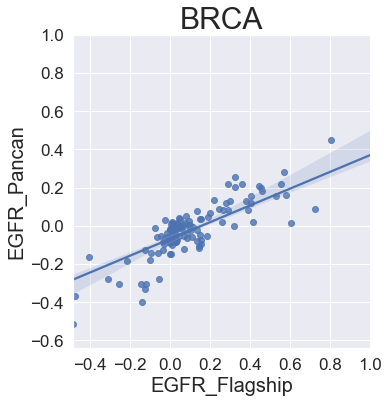

In [28]:
plot_pearson(both,"EGFR_Flagship","EGFR_Pancan",title = "BRCA", hue = "none", ra_stats = False ,show_plot = True)

In [ ]:

def add_del_and_amp(row):
            if row[col_name] <= -.2:
                mutations = 'Deletion'
               
            elif row[col_name] >= .2:
                mutations = 'Amplification'
               
            else:
                mutations = "No_CNV_mut"

            return mutations  

In [ ]:
col_name = "EGFR_Pancan"
both['Pancan_CNV_status'] = (both.apply(add_del_and_amp, axis=1))
col_name = "EGFR_Flagship"
both['Flagship_CNV_status'] = (both.apply(add_del_and_amp, axis=1))
both



In [ ]:
def find_match(row):
    if row["Pancan_CNV_status"] == row["Flagship_CNV_status"]:
        match = True
    else:
        match = False
            
    return match

In [ ]:
both['Match'] = (both.apply(find_match, axis=1))
both

In [ ]:
pd.set_option('display.max_rows', None)
both['Difference'] =both["EGFR_Flagship"] - both["EGFR_Pancan"]
both

In [ ]:
pd.set_option('display.max_rows', None)
both_no_match = both.loc[both["Match"] == False]

#Cancer Type Breast: 5 no CNV flagship now Deletion. 22 were amplification and now are not 
both_no_match

In [ ]:
both.Difference.mean()

In [ ]:
both_no_match.Difference.mean()

LSCC

In [18]:
og_lscc = cptac.Lscc()
og_lscc

In [19]:
og_lscc_cnv = og_lscc.get_CNV()
og_lscc_cnv = og_lscc_cnv[["EGFR"]]
og_lscc_cnv = og_lscc_cnv.rename(columns = {"EGFR":"EGFR_Flagship"})

lscc_CNV = ls.get_CNV(source = "washu")
lscc_CNV = lscc_CNV[["EGFR"]]
lscc_CNV = lscc_CNV.rename(columns = {"EGFR":"EGFR_Pancan"})
drop = ['Database_ID']
lscc_CNV = ut.reduce_multiindex(df=lscc_CNV, levels_to_drop=drop)    


NameError: name 'ut' is not defined

In [ ]:
import cptac.utils as ut
both_lscc = lscc_CNV.join(og_lscc_cnv, how = "left")
drop = ['Database_ID']
#both_lscc = ut.reduce_multiindex(df=both_lscc, levels_to_drop=drop)    
both_lscc

In [27]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math as math
import scipy.stats
import re
import sys
import statsmodels.stats.multitest


def plot_pearson(df1,x_axis, y_axis, hue = "none", title = "", ra_stats = False, x_coor= 1.0 , y_coor = 1.0, show_plot = True, pval_trunc = 5 , x_label = "x_label", y_label = "y_label", save_file_name = "file_name"):
    #add option to insert own axis labels or by default 
    if x_label == "x_label":
        x_label = x_axis
    if y_label == "y_label":
        y_label = y_axis
        
    if hue != "none":   
      
        df1_subset = df1[[x_axis,y_axis,hue]]
        df1_subset = df1_subset.dropna(axis=0, how="any")
        count_row = df1_subset.shape[0]
        if count_row > 30:
            x1 = df1_subset[[x_axis]].values
            y1 = df1_subset[[y_axis]].values
            x1 = x1[:,0]
            y1 = y1[:,0]
            corr, pval = scipy.stats.pearsonr(x1,y1)

            sns.set(style="darkgrid")
            plt.rcParams["figure.figsize"] = (30,22)
            graph = sns.lmplot(x= x_axis, y= y_axis, data=df1_subset, hue= hue, fit_reg=False)
            sns.regplot(x=x1, y=y1, data=df1_subset,scatter = False)
            plt.xlabel(x_label, fontsize=20)
            plt.ylabel( y_label, fontsize=20)
            graph.set(title = title)
        else:
            return 0

    if hue == "none":
        
        df1_subset = df1[[x_axis,y_axis]]
        df1_subset = df1_subset.dropna(axis=0, how="any")
        count_row = df1_subset.shape[0]
        if count_row > 30:
            x1 = df1_subset[[x_axis]].values
            y1 = df1_subset[[y_axis]].values
            x1 = x1[:,0]
            y1 = y1[:,0]
            corr, pval = scipy.stats.pearsonr(x1,y1)

            sns.set(style="darkgrid")
            graph = sns.lmplot(x= x_axis, y= y_axis, data=df1_subset, fit_reg=False)
            sns.regplot(x=x1, y=y1, data=df1_subset,scatter = False)
            plt.title(label = title, fontsize = 30)
            plt.xlabel(x_label, fontsize=20)
            plt.ylabel( y_label, fontsize=20)
            plt.xlim(right=1)  
            plt.ylim(top = 1) 
            plt.xticks(fontsize = 17)
            plt.yticks(fontsize = 17)
        else:
            return 0

    if ra_stats:
        pval = myTrunc(pval,pval_trunc)
        corr = myTrunc(corr,3)
        plt.text(x_coor,y_coor, "Correlation: %s\nPvalue: %s"%(corr,pval), fontsize = 17)
        
    if save_file_name != "file_name":
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.savefig(save_file_name+'.png', dpi = 300)
    if show_plot:
        
        plt.show()
        plt.clf()
        plt.close()


In [ ]:
plot_pearson(both_lscc,"EGFR_Flagship","EGFR_Pancan",title ="LSCC", hue = "none", ra_stats = False ,show_plot = True)

In [ ]:
col_name = "EGFR_Pancan"
both_lscc['Pancan_CNV_status'] = (both_lscc.apply(add_del_and_amp, axis=1))
col_name = "EGFR_Flagship"
both_lscc['Flagship_CNV_status'] = (both_lscc.apply(add_del_and_amp, axis=1))
both_lscc

In [ ]:
both_lscc['Difference'] =both_lscc["EGFR_Flagship"] - both_lscc["EGFR_Pancan"]
both_lscc['Match'] = (both_lscc.apply(find_match, axis=1))
both_lscc

In [ ]:
both_no_match = both_lscc.loc[both_lscc["Match"] == False]
both_no_match
#Cancer type LSCC 16 fewer Amp from 

In [ ]:
print(both.Difference.mean())
both_lscc.Difference.mean()

In [ ]:
both_no_match.Difference.mean()

In [ ]:
both_lscc_no